In [ ]:
pip install qiskit==2.1

In [ ]:
pip install qiskit_aer==0.17

In [ ]:
pip install qiskit_ibm_runtime==0.40

In [ ]:
pip install numpy==2.2

In [ ]:
pip install pylatexenc==2.10

In [ ]:
pip install matplotlib==3.10

# Chapter 4. Coding One-Qubit Protocols in Qiskit

## 4.2. How to work with one qubit in Qiskit

In [1]:
from qiskit import QuantumCircuit

In [2]:
circuit = QuantumCircuit(1) # We specify "1" for one qubit.

In [3]:
circuit.x(0) # Apply an X gate on the fist qubit (0).
circuit.h(0) # Apply an H gate.

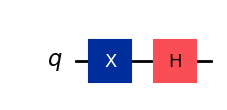

In [4]:
circuit.draw("mpl")

In [5]:
drawing = circuit.draw("mpl")
#drawing.savefig("circuit.pdf") # Uncomment to save the file!

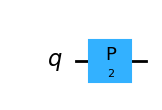

In [6]:
# Apply the gate P(2) on a one-qubit circuit.
circuit = QuantumCircuit(1)
circuit.p(2,0)
circuit.draw("mpl")

In [7]:
def phased_circuit(phase):
    circuit = QuantumCircuit(1)
    if phase < 1:
        circuit.p(phase, 0)
    else:
        circuit.h(0)
    return circuit

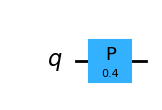

In [8]:
phased_circuit(0.4).draw("mpl")

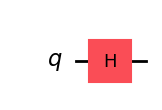

In [9]:
phased_circuit(1.1).draw("mpl")

### Simulating the evolution of a state

In [10]:
circuit = QuantumCircuit(1)
circuit.x(0)
circuit.h(0)

In [11]:
from qiskit.quantum_info import Statevector

state = Statevector(circuit)
print(state)

Statevector([ 0.70710678+0.j, -0.70710678+0.j],
            dims=(2,))


### Getting samples from a simulator

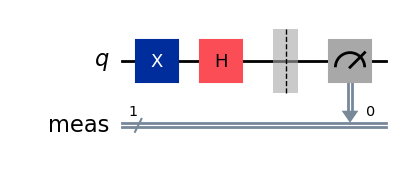

In [12]:
circuit.measure_all()
circuit.draw("mpl")

In [13]:
from qiskit_aer import AerSimulator
backend = AerSimulator(seed_simulator = 18620123)

In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend)

In [15]:
job = sampler.run([circuit], shots = 8)
result = job.result()[0].data.meas # Get the results!

In [16]:
print(result.get_counts())

{'0': 5, '1': 3}


In [17]:
print(result.get_bitstrings())

['0', '1', '0', '1', '0', '1', '0', '0']


In [18]:
print(result.array)

[[0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]]


### Getting results from real quantum hardware

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
token = "YOUR API KEY GOES HERE"
service = QiskitRuntimeService(token = token, channel = "ibm_quantum_platform")

In [ ]:
# Use the code below to save your account on your computer.
# QiskitRuntimeService.save_account(token = token, channel = "ibm_quantum_platform")

In [21]:
backend = service.least_busy(simulator = False, operational = True)
print(backend)

<IBMBackend('ibm_sherbrooke')>


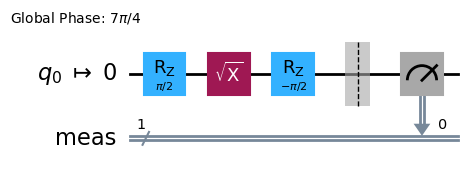

In [22]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled = pm.run(circuit) 
transpiled.draw("mpl", idle_wires = False)

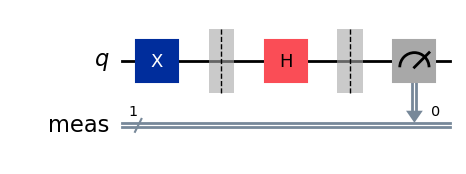

In [23]:
circuit_barrier = QuantumCircuit(1)
circuit_barrier.x(0)
circuit_barrier.barrier()
circuit_barrier.h(0)
circuit_barrier.measure_all()
circuit_barrier.draw("mpl")

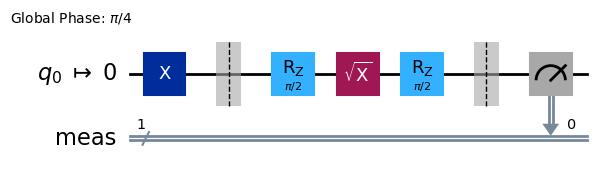

In [24]:
transpiled_barrier = pm.run(circuit_barrier) 
transpiled_barrier.draw("mpl", idle_wires = False)

In [25]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
job = sampler.run([transpiled], shots = 1024)
result = job.result()[0].data.meas
print(result.get_counts())

{'0': 535, '1': 489}


## 4.3. Implementing the BB84 protocol

In [26]:
import random
random.seed(18620123)
backend = AerSimulator(seed_simulator = 18620123)
sampler = Sampler(backend)

In [27]:
# The key we want to send:
alice_bits = [0,1,0,1,1,1,0,0,1,1,0]
# A list for the bits that bob will receive:
bob_bits = []

# We will create lists to store wheteher Alice/Bob used H.
# If they do, we add "True", otherwise we add "False".
alice_used_h = []
bob_used_h = []

In [28]:
for bit in alice_bits:
    circuit = QuantumCircuit(1)
    # If we are going to send 1, we apply an X gate.
    # Remember that the state is initialized to |0>.
    if bit:
        circuit.x(0)
        
    # Choose at random if Alice applies H, and do it.
    alice_h = random.choice([True, False])
    if alice_h:
        circuit.h(0)
        
    # Apply a barrier and choose whether Bob does H, and do it.
    circuit.barrier()
    bob_h = random.choice([True, False])
    if bob_h:
        circuit.h(0)

    # Measure the qubit (on Bob's end).
    circuit.measure_all()
    job = sampler.run([circuit], shots = 1)
    bob_bit = int(job.result()[0].data.meas.get_bitstrings()[0])

    # Add the measured bit to bob_bits and record who used H.
    bob_bits.append(bob_bit)
    alice_used_h.append(alice_h)
    bob_used_h.append(bob_h)

In [29]:
# List of indices where Alice and Bob agree on whether to apply H.
agree = [i for i in range(len(alice_bits)) if alice_bits[i] == bob_bits[i]]

In [30]:
# Get the sent/received bits when they agree on applying H.
alice = [alice_bits[i] for i in agree]
bob = [bob_bits[i] for i in agree]

print(alice)
print(bob)

[0, 0, 1, 1, 0, 0, 1, 0]
[0, 0, 1, 1, 0, 0, 1, 0]
